# Векторизация текстов: практическая работа.
Выполнил: Новиков Павел  

Группа: DSPR-77

In [ ]:
!pip install datasets --quiet
!pip install tokenizers --quiet
#!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# import numpy as np
import time

import datasets
import tokenizers
from sklearn.metrics import accuracy_score
# import wandb
# from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# Задание:

**IMDB** - это датасет по классификации эмоциональной окраски.   
Нам нужно предсказать положительный ли отзыв к фильму по его тексту.   
Для доступа к нему мы используем библиотеку `datasets`

Тренировочная и тестовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

In [ ]:
text_dataset = datasets.load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
type(text_dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
text_dataset.shape

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}

In [ ]:
text_dataset.column_names

{'train': ['text', 'label'],
 'test': ['text', 'label'],
 'unsupervised': ['text', 'label']}

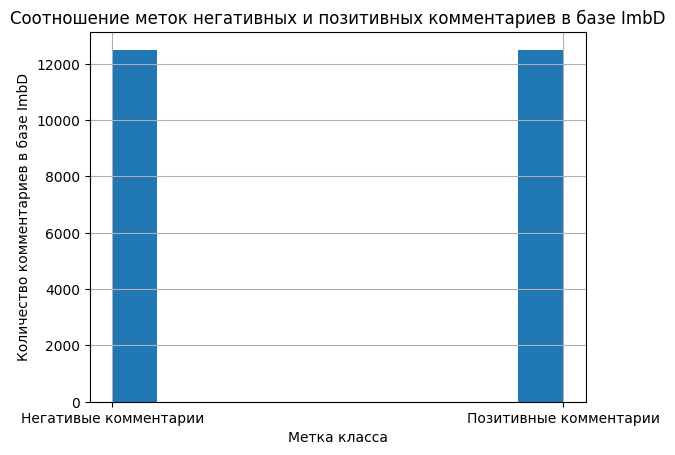

In [ ]:
# определим сбалансированность классов
train_labels = [e['label'] for e in text_dataset['train']]
plt.hist(train_labels)
plt.xlabel('Метка класса')
plt.xticks([0,1], ['Негативые комментарии','Позитивные комментарии'])
plt.ylabel('Количество комментариев в базе ImbD')
plt.title('Соотношение меток негативных и позитивных комментариев в базе ImbD')
plt.grid(True)
plt.locator_params (axis='x', nbins= 2 )
plt.show()

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

# 1. Baseline-модель. Классификация с использованием линейной модели логистической регрессии

Используем библиотеку `sklearn` для создания линейной модели. Для векторизации текста мы будем использовать `TfidfVectorizer`, а в качестве модели `LogisticRegression`.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# создадим и обучим объект векторизации TfidfVectorizer
vectorizer  = TfidfVectorizer()
values = vectorizer.fit(text_dataset['train']['text'])


In [ ]:
# 1.конвертируем тексты(обучающий и тестовый) в векторы tf-idf
# 2 конвертируем метки класса в массивы numpy
X_train = values.transform(text_dataset['train']['text'])
y_train = text_dataset['train'].with_format('numpy', columns=['label'])['label']

X_test = values.transform(text_dataset['test']['text'])
y_test = text_dataset['test'].with_format("numpy", columns=['label'])['label']

In [ ]:
%%time
# создадим и обучим модель логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)
# А теперь мы используем нашу модель для того, чтобы предсказать классы на тестовых данных
predictions = model.predict(X_test)

CPU times: user 3.32 s, sys: 3.84 s, total: 7.16 s
Wall time: 3.85 s


In [ ]:
text_dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
ff2 = values.transform(text_dataset['train']['text'][0:2])
# ff2 = values.transform(['в лесу'],['родилась елочка'])
ff1 = values.transform(text_dataset['train']['text'][0:1])
fn = values.get_feature_names_out()

In [ ]:
import pandas as pd

In [ ]:
ff2

<2x74849 sparse matrix of type '<class 'numpy.float64'>'
	with 324 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame(ff2.toarray(),columns=fn)

,00,000,0000000000001,00001,00015,000s,001,003830,006,007,...,était,état,étc,évery,êxtase,ís,ísnt,østbye,über,üvegtigris
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.DataFrame(ff1.toarray(),columns=fn)

,00,000,0000000000001,00001,00015,000s,001,003830,006,007,...,était,état,étc,évery,êxtase,ís,ísnt,østbye,über,üvegtigris
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ff1.shape

(1, 74849)

In [ ]:
ff2.shape

(2, 74849)

In [ ]:
# определим совпадают ли типы данных для расчета метрики accuracy
print('Совпадают ли типы данных предсказаний и меток тестовых данных: {}'.format(type(predictions) == type(y_test)))
# рассчитаем метрику accuracy
accuracy = (predictions == y_test).mean()
print('Модель Baseline(LogisticRegression()). Значение метрики accuracy: {}'.format(accuracy))

Совпадают ли типы данных предсказаний и меток тестовых данных: True
Модель Baseline(LogisticRegression()). Значение метрики accuracy: 0.88316


С помощью созданной модели логистической регрессии предскажем, позитивны ли следующие комментарии:

In [ ]:
positive_comment = 'This movie is awesome!'

vec = vectorizer.transform([positive_comment])
if model.predict(vec)[0] == 1:
  marks = 'Позитивный'
else: marks = 'Негативный'

print('Оцениваемый комментарий: {}'.format(positive_comment))
print('Предсказание оценки комментария: {}.'.format(marks))

Оцениваемый комментарий: This movie is awesome!
Предсказание оценки комментария: Позитивный.


In [ ]:
negative_comment = 'This movie is awful!'

vec = vectorizer.transform([negative_comment])
if model.predict(vec)[0] == 1:
  marks = 'Позитивный'
else: marks = 'Негативный'

print('Оцениваемый комментарий: {}'.format(negative_comment))
print('Предсказание оценки комментария: {}.'.format(marks))

Оцениваемый комментарий: This movie is awful!
Предсказание оценки комментария: Негативный.


Вывод: даже такая простая модель может хорошо классифицировать текст.

# 2. Модель линейной регресии LinearSVM
Определим насколько изменится метрика при использовании алгоритма опорных векторов LinearSVM.
Во время использования данного алгоритма определяется гиперплоскость наиболее точно разделяющая признаки и после удаления точек данных, наиболее близко находящихся к гиперплоскости максимизируется точность классификации.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
%%time
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Модель линейной регрессии LinearSVM()). Значение метрики accuracy: {}'.format(accuracy_score(y_test,y_pred)))

# 3. Линейная регрессия LinearRegression() с использованием n-gram в токенизаторе TF-IDF.
Проведем токенизацию текста отзыва с использованием юни- и биграмм.
Для того, чтобы избежать переобучения от большого количества признаков установим параметр `max_features` = 50 000

In [ ]:
vectorizer_ngrams  = TfidfVectorizer(ngram_range=(1, 2), max_features = 50000)
values_adv = vectorizer_ngrams.fit(text_dataset['train']['text'])

X_train = values_adv.transform(text_dataset['train']['text'])
y_train = text_dataset['train'].with_format('numpy', columns=['label'])['label']

X_test = values_adv.transform(text_dataset['test']['text'])
y_test = text_dataset['test'].with_format("numpy", columns=['label'])['label']

In [ ]:
%%time
model_adv = LogisticRegression()
model_adv.fit(X_train, y_train)

predictions = model_adv.predict(X_test)

print('Модель линейной регрессии LinearRegression() c использованием n-грамм в токенизаторе TF-IDF. Значение метрики accuracy: {}'\
      .format(accuracy_score(y_test, predictions)))

# 4.Модель линейной регресии LinearSVM с использованием n-gram в токенизаторе TF-IDF.
И, наконец используем сочетание токенизации текста отзыва с использованием юни- и биграмм и метод опорных векторов.
Для того, чтобы избежать переобучения от большого количества признаков установим параметр max_features = 50 000

In [ ]:
%%time
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Модель линейной регрессии LinearSVM() c использованием n-грамм в токенизаторе TF-IDF. Значение метрики accuracy: {}'\
      .format(accuracy_score(y_test, y_pred)))

**Результаты:**
1. Baseline: LogisticRegression() + векторизатор TF-IDF
```
Время выполнения: 3.68 s
Значение метрики accuracy: 0.88316
```
2. LinearSVM + векторизатор TF-IDF
```
Время выполнения:  21min 24s
Значение метрики accuracy: 0.88256
```
3. LogisticRegression() + N-грамма в векторизаторе TF-IDF
```
Время выполнения: 4.23 s
Значение метрики accuracy: 0.89436
```
4. LinearSVM + N-грамма в векторизаторе TF-IDF
```
Время выполнения: 40min 24s
Значение метрики accuracy: 0.89872
```
**Выводы:** Наилучшее качество классификации негативных и положительных отзывов показала модель линейной регресии LinearSVM с использованием n-gram в токенизаторе TF-IDF с показателем метрики accuracy = 0.89872 т.е. примерно в ~90% случаев модель правильно угадала окраску отзыва.  
Выигрыш по сравнению с Baseline составил ~1,5%.
Однако, если проанализировать затраты времени на работу модели, то становится очевидно, что такой прогресс явился следствием почти 660 кратного увеличения временных затрат.   
Учитывая, что качество предсказания достаточно высокое, а речь не идет об предсказании болезней или вещей, представляющих угрозу безопасности человека, то использование данной модели представляется нецелесообразным.  
Так же как и 2 вариант(LinearSVM + векторизатор TF-IDF) с меньшим, чем у Baseline качеством и значительным увеличением времени выполнения.  
3 вариант реализации(LogisticRegression() + N-грамма в векторизаторе TF-IDF) хоть и дает выигрыш в качестве предсказания на 1.1%, однако времени затрачивает 6.7% больше.   
Следовательно вариант реализации модели Baseline(LogisticRegression()) представляется наиболее оптимальным.



In [ ]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving отзывы_за_лето.xls to отзывы_за_лето.xls
User uploaded file "отзывы_за_лето.xls" with length 3596800 bytes


In [ ]:
from google.colab import files
files.download('/content/отзывы_за_лето.xls')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>